In [1]:
import os
from importlib.resources import files

import copy
import numpy as np
import torch
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry, SecondGeometry, LinearField
from learn_embedding.utils import *
from learn_embedding.loss import *

## Load Dataset

In [2]:
dim = 2
num_traj = 3  # Number of trajectories
num_samples = 1000  # Desired number of samples per trajectory

train_x = np.empty((0, 4))
train_y = np.empty((0, 2))

for i in range(1, num_traj + 1):
    # Load trajectory data
    data = np.loadtxt("../learn_embedding/data/toycase/trajectory_" + str(i) + ".csv")
    
    # subsample
    idx = DataProcess.subsample(data[:,:2], num_samples)
    data[idx,:2] -= data[-1,:2]
    data[-1,2:4] = np.zeros(2)
    data[-1,-2:] = np.zeros(2)
    
    # add to datset
    train_x = np.append(train_x, data[idx,:4], axis=0)
    train_y = np.append(train_y, data[idx,-2:], axis=0)

## Torch Configuration

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
train_x = torch.from_numpy(train_x).float().to(device).requires_grad_(True)
train_y = torch.from_numpy(train_y).float().to(device)

## Create Model

In [4]:
# model_first = FirstGeometry(Embedding(FeedForward(dim, [64]*2, 1)), 
#                       torch.tensor([0.0,0.0]).to(device), 
#                       SPD(dim)).to(device)
# TorchHelper.load(model_first,'../outputs/Khamesh_1')

In [5]:
# torch.manual_seed(1337)

# approximator = KernelExpansion(train_x[:, :dim])
# approximator = KernelMachine(dim, 1000, 1, length=0.4)

num_neurons = [64]
num_layers = 2
approximator = FeedForward(dim, num_neurons*num_layers, 1)

# embedding = copy.deepcopy(model_first.embedding)
# TorchHelper.set_grad(embedding, False)
embedding = Embedding(approximator)

# stiffness = copy.deepcopy(model_first.stiffness)
# dissipation = copy.deepcopy(model_first.stiffness)
# dissipation.eigval = 2*dissipation.eigval
# stiffness = Spherical()
# dissipation = Spherical()
stiffness = SPD(dim)
dissipation = SPD(dim)

attractor = train_x[-1][:2].detach()

field = LinearField(attractor, Spherical(1.0, True))
field_weight = 1.0

model = SecondGeometry(embedding, attractor, stiffness, dissipation).to(device)
# TorchHelper.load(model, '../outputs/' + dataset + '_2')
# model.velocity_embedding = False
# TorchHelper.set_grad(model_first, False)

## Train

In [6]:
trainer = Trainer(model, train_x, train_y)

trainer.optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
# trainer.optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2, weight_decay=1e-1)

trainer.loss = torch.nn.MSELoss()
# trainer.loss = torch.nn.SmoothL1Loss()
# trainer.loss = WeighedMagnitudeDirectionLoss(magnitude_weight=0.0, direction_weight=1.0)

trainer.options(normalize=False, shuffle=True, print_loss=True,epochs=1000)

trainer.train()
# TorchHelper.save(model, '../outputs/' + dataset + '_2')

EPOCH:  0 ITER:  0 LR:  0.01 LOSS:  0.2246483862400055
EPOCH:  1 ITER:  0 LR:  0.01 LOSS:  0.10750017315149307
EPOCH:  2 ITER:  0 LR:  0.01 LOSS:  0.044946637004613876
EPOCH:  3 ITER:  0 LR:  0.01 LOSS:  0.028023583814501762
EPOCH:  4 ITER:  0 LR:  0.01 LOSS:  0.024419156834483147
EPOCH:  5 ITER:  0 LR:  0.01 LOSS:  0.02351580746471882
EPOCH:  6 ITER:  0 LR:  0.01 LOSS:  0.02298247441649437
EPOCH:  7 ITER:  0 LR:  0.01 LOSS:  0.02251090668141842
EPOCH:  8 ITER:  0 LR:  0.01 LOSS:  0.022108376026153564
EPOCH:  9 ITER:  0 LR:  0.01 LOSS:  0.021757740527391434
EPOCH:  10 ITER:  0 LR:  0.01 LOSS:  0.021405832841992378
EPOCH:  11 ITER:  0 LR:  0.01 LOSS:  0.02100578136742115
EPOCH:  12 ITER:  0 LR:  0.01 LOSS:  0.02054070308804512
EPOCH:  13 ITER:  0 LR:  0.01 LOSS:  0.020021971315145493
EPOCH:  14 ITER:  0 LR:  0.01 LOSS:  0.019475113600492477
EPOCH:  15 ITER:  0 LR:  0.01 LOSS:  0.018924759700894356
EPOCH:  16 ITER:  0 LR:  0.01 LOSS:  0.018384594470262527
EPOCH:  17 ITER:  0 LR:  0.01 LO

EPOCH:  145 ITER:  0 LR:  0.01 LOSS:  0.004309845622628927
EPOCH:  146 ITER:  0 LR:  0.01 LOSS:  0.0041761239990592
EPOCH:  147 ITER:  0 LR:  0.01 LOSS:  0.00406928826123476
EPOCH:  148 ITER:  0 LR:  0.01 LOSS:  0.003982859198004007
EPOCH:  149 ITER:  0 LR:  0.01 LOSS:  0.00392006803303957
EPOCH:  150 ITER:  0 LR:  0.01 LOSS:  0.0038835087325423956
EPOCH:  151 ITER:  0 LR:  0.01 LOSS:  0.00390771497040987
EPOCH:  152 ITER:  0 LR:  0.01 LOSS:  0.004198471084237099
EPOCH:  153 ITER:  0 LR:  0.01 LOSS:  0.004316400736570358
EPOCH:  154 ITER:  0 LR:  0.01 LOSS:  0.004333578981459141
EPOCH:  155 ITER:  0 LR:  0.01 LOSS:  0.003524144645780325
EPOCH:  156 ITER:  0 LR:  0.01 LOSS:  0.004254452418535948
EPOCH:  157 ITER:  0 LR:  0.01 LOSS:  0.0047293598763644695
EPOCH:  158 ITER:  0 LR:  0.01 LOSS:  0.0037041958421468735
EPOCH:  159 ITER:  0 LR:  0.01 LOSS:  0.004816493019461632
EPOCH:  160 ITER:  0 LR:  0.01 LOSS:  0.003506647190079093
EPOCH:  161 ITER:  0 LR:  0.01 LOSS:  0.004105186555534601

EPOCH:  289 ITER:  0 LR:  0.01 LOSS:  0.001542162150144577
EPOCH:  290 ITER:  0 LR:  0.01 LOSS:  0.0014796749455854297
EPOCH:  291 ITER:  0 LR:  0.01 LOSS:  0.001414699014276266
EPOCH:  292 ITER:  0 LR:  0.01 LOSS:  0.0013955705799162388
EPOCH:  293 ITER:  0 LR:  0.01 LOSS:  0.0014180918224155903
EPOCH:  294 ITER:  0 LR:  0.01 LOSS:  0.0014508827589452267
EPOCH:  295 ITER:  0 LR:  0.01 LOSS:  0.0014706323854625225
EPOCH:  296 ITER:  0 LR:  0.01 LOSS:  0.0014384206151589751
EPOCH:  297 ITER:  0 LR:  0.01 LOSS:  0.0014015414053574204
EPOCH:  298 ITER:  0 LR:  0.01 LOSS:  0.0013727525947615504
EPOCH:  299 ITER:  0 LR:  0.01 LOSS:  0.0013652604538947344
EPOCH:  300 ITER:  0 LR:  0.01 LOSS:  0.0013759667053818703
EPOCH:  301 ITER:  0 LR:  0.01 LOSS:  0.0013945571845397353
EPOCH:  302 ITER:  0 LR:  0.01 LOSS:  0.001416218699887395
EPOCH:  303 ITER:  0 LR:  0.01 LOSS:  0.001425527734681964
EPOCH:  304 ITER:  0 LR:  0.01 LOSS:  0.0014349271077662706
EPOCH:  305 ITER:  0 LR:  0.01 LOSS:  0.0014

EPOCH:  430 ITER:  0 LR:  0.01 LOSS:  0.0010320863220840693
EPOCH:  431 ITER:  0 LR:  0.01 LOSS:  0.0010375158162787557
EPOCH:  432 ITER:  0 LR:  0.01 LOSS:  0.0010492904111742973
EPOCH:  433 ITER:  0 LR:  0.01 LOSS:  0.0010551064042374492
EPOCH:  434 ITER:  0 LR:  0.01 LOSS:  0.0010673855431377888
EPOCH:  435 ITER:  0 LR:  0.01 LOSS:  0.0010617425432428718
EPOCH:  436 ITER:  0 LR:  0.01 LOSS:  0.0010570333106443286
EPOCH:  437 ITER:  0 LR:  0.01 LOSS:  0.001032857340760529
EPOCH:  438 ITER:  0 LR:  0.01 LOSS:  0.0010109557770192623
EPOCH:  439 ITER:  0 LR:  0.01 LOSS:  0.0009870269568637013
EPOCH:  440 ITER:  0 LR:  0.01 LOSS:  0.0009718062356114388
EPOCH:  441 ITER:  0 LR:  0.01 LOSS:  0.0009643760859034956
EPOCH:  442 ITER:  0 LR:  0.01 LOSS:  0.000963937200140208
EPOCH:  443 ITER:  0 LR:  0.01 LOSS:  0.000968418491538614
EPOCH:  444 ITER:  0 LR:  0.01 LOSS:  0.0009764969581738114
EPOCH:  445 ITER:  0 LR:  0.01 LOSS:  0.0009894291870296001
EPOCH:  446 ITER:  0 LR:  0.01 LOSS:  0.001

EPOCH:  568 ITER:  0 LR:  0.01 LOSS:  0.0008950578630901873
EPOCH:  569 ITER:  0 LR:  0.01 LOSS:  0.0009123067720793188
EPOCH:  570 ITER:  0 LR:  0.01 LOSS:  0.0010162421967834234
EPOCH:  571 ITER:  0 LR:  0.01 LOSS:  0.0009172370191663504
EPOCH:  572 ITER:  0 LR:  0.01 LOSS:  0.0008892207988537848
EPOCH:  573 ITER:  0 LR:  0.01 LOSS:  0.0008025274728424847
EPOCH:  574 ITER:  0 LR:  0.01 LOSS:  0.0007665486191399395
EPOCH:  575 ITER:  0 LR:  0.01 LOSS:  0.0007602169062010944
EPOCH:  576 ITER:  0 LR:  0.01 LOSS:  0.0007765637128613889
EPOCH:  577 ITER:  0 LR:  0.01 LOSS:  0.0008174058748409152
EPOCH:  578 ITER:  0 LR:  0.01 LOSS:  0.000851757766213268
EPOCH:  579 ITER:  0 LR:  0.01 LOSS:  0.0009417135734111071
EPOCH:  580 ITER:  0 LR:  0.01 LOSS:  0.0008997991681098938
EPOCH:  581 ITER:  0 LR:  0.01 LOSS:  0.0009097807924263179
EPOCH:  582 ITER:  0 LR:  0.01 LOSS:  0.000833449768833816
EPOCH:  583 ITER:  0 LR:  0.01 LOSS:  0.0008017079089768231
EPOCH:  584 ITER:  0 LR:  0.01 LOSS:  0.00

EPOCH:  708 ITER:  0 LR:  0.01 LOSS:  0.0006447743508033454
EPOCH:  709 ITER:  0 LR:  0.01 LOSS:  0.000652135000564158
EPOCH:  710 ITER:  0 LR:  0.01 LOSS:  0.0006700970116071403
EPOCH:  711 ITER:  0 LR:  0.01 LOSS:  0.0006852532387711108
EPOCH:  712 ITER:  0 LR:  0.01 LOSS:  0.0007317603449337184
EPOCH:  713 ITER:  0 LR:  0.01 LOSS:  0.0007357641588896513
EPOCH:  714 ITER:  0 LR:  0.01 LOSS:  0.0008002096437849104
EPOCH:  715 ITER:  0 LR:  0.01 LOSS:  0.0007468522526323795
EPOCH:  716 ITER:  0 LR:  0.01 LOSS:  0.0007519961800426245
EPOCH:  717 ITER:  0 LR:  0.01 LOSS:  0.0006920474697835743
EPOCH:  718 ITER:  0 LR:  0.01 LOSS:  0.0006681212107650936
EPOCH:  719 ITER:  0 LR:  0.01 LOSS:  0.0006511987885460258
EPOCH:  720 ITER:  0 LR:  0.01 LOSS:  0.0006466983468271792
EPOCH:  721 ITER:  0 LR:  0.01 LOSS:  0.0006512438412755728
EPOCH:  722 ITER:  0 LR:  0.01 LOSS:  0.0006549222744069993
EPOCH:  723 ITER:  0 LR:  0.01 LOSS:  0.000666647800244391
EPOCH:  724 ITER:  0 LR:  0.01 LOSS:  0.00

EPOCH:  846 ITER:  0 LR:  0.01 LOSS:  0.0006310329772531986
EPOCH:  847 ITER:  0 LR:  0.01 LOSS:  0.0005929831531830132
EPOCH:  848 ITER:  0 LR:  0.01 LOSS:  0.00057643698528409
EPOCH:  849 ITER:  0 LR:  0.01 LOSS:  0.0005694042192772031
EPOCH:  850 ITER:  0 LR:  0.01 LOSS:  0.0005739826010540128
EPOCH:  851 ITER:  0 LR:  0.01 LOSS:  0.0005759273772127926
EPOCH:  852 ITER:  0 LR:  0.01 LOSS:  0.0005764471716247499
EPOCH:  853 ITER:  0 LR:  0.01 LOSS:  0.000570686359424144
EPOCH:  854 ITER:  0 LR:  0.01 LOSS:  0.000565851922146976
EPOCH:  855 ITER:  0 LR:  0.01 LOSS:  0.0005653129192069173
EPOCH:  856 ITER:  0 LR:  0.01 LOSS:  0.0005699803004972637
EPOCH:  857 ITER:  0 LR:  0.01 LOSS:  0.0005876902141608298
EPOCH:  858 ITER:  0 LR:  0.01 LOSS:  0.0006021076114848256
EPOCH:  859 ITER:  0 LR:  0.01 LOSS:  0.0006470560911111534
EPOCH:  860 ITER:  0 LR:  0.01 LOSS:  0.0006446889019571245
EPOCH:  861 ITER:  0 LR:  0.01 LOSS:  0.0006957351579330862
EPOCH:  862 ITER:  0 LR:  0.01 LOSS:  0.0006

EPOCH:  987 ITER:  0 LR:  0.01 LOSS:  0.0005975026870146394
EPOCH:  988 ITER:  0 LR:  0.01 LOSS:  0.0006194813759066164
EPOCH:  989 ITER:  0 LR:  0.01 LOSS:  0.0006011668010614812
EPOCH:  990 ITER:  0 LR:  0.01 LOSS:  0.0005269054090604186
EPOCH:  991 ITER:  0 LR:  0.01 LOSS:  0.0005127009935677052
EPOCH:  992 ITER:  0 LR:  0.01 LOSS:  0.0005618309951387346
EPOCH:  993 ITER:  0 LR:  0.01 LOSS:  0.0005890908068977296
EPOCH:  994 ITER:  0 LR:  0.01 LOSS:  0.0005989592173136771
EPOCH:  995 ITER:  0 LR:  0.01 LOSS:  0.0005480897380039096
EPOCH:  996 ITER:  0 LR:  0.01 LOSS:  0.0005485194269567728
EPOCH:  997 ITER:  0 LR:  0.01 LOSS:  0.0005701681948266923
EPOCH:  998 ITER:  0 LR:  0.01 LOSS:  0.0005998973501846194
EPOCH:  999 ITER:  0 LR:  0.01 LOSS:  0.0005781117943115532


## Plot

In [7]:
resolution = 100
std = train_x.detach().std(axis=0)
min_ax = train_x.detach().min(axis=0)[0] - std/2
max_ax = train_x.detach().max(axis=0)[0] + std/2
x, y = torch.meshgrid(torch.linspace(min_ax[0], max_ax[0], resolution), torch.linspace(min_ax[1], max_ax[1], resolution), indexing='xy')

grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
grid_v = torch.zeros_like(grid_x).to(device).requires_grad_(True)

grid_xr = torch.stack((torch.ravel(x[10::10,10::10]), torch.ravel(y[10::10,10::10])), dim=1).to(device).requires_grad_(True)
grid_vr = torch.zeros_like(grid_xr).to(device).requires_grad_(True)

theta = torch.linspace(0, 2*torch.pi, steps=50).to(device)

### Potential

In [8]:
potential = model.potential(grid_x).reshape(resolution, -1).cpu().detach().numpy()

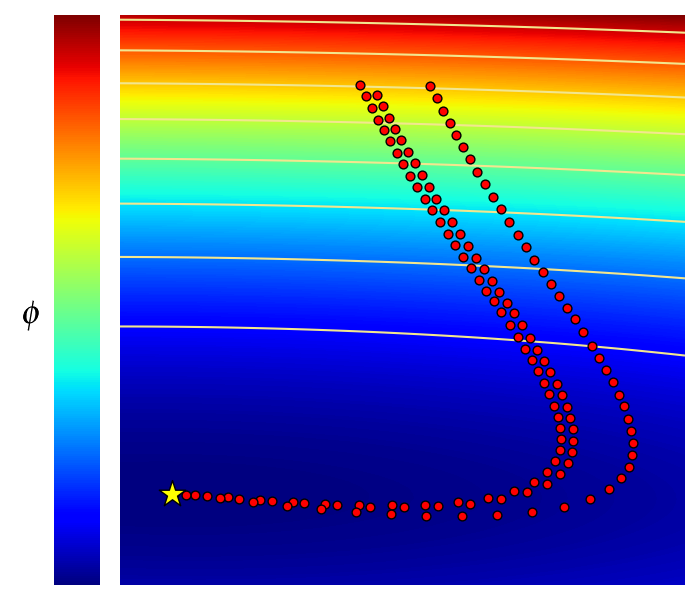

In [33]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(7, 6))

steps = 20
im = ax.contourf(x, y, potential, 500, cmap="jet")
ax.contour(x, y, potential, 10, cmap=None, colors='#f2e68f')
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="8%", pad=0.2)
cax.yaxis.set_label_position("left")
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=-50)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

# Adjust layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_potential_second.png', format='png', dpi=300, bbox_inches="tight")

### Vector Field

In [10]:
obstacle_radius = 0.1 # 0.05 , 0.1
obstacle = torch.tensor([[-0.4,-0.4]])
# obstacle = Obstacles.square(center=torch.tensor([-30,20]), a=20, b=20, res=10)
# obstacle = Obstacles.semi_circle(radius=0.2, center=torch.tensor([-0.4,   -0.4]), rot=torch.tensor(torch.pi/4), res=50)
decay = 5e-1
lengthscale = np.sqrt(-0.5*obstacle_radius**2/np.log(decay))
# phi = KernelExpansion(obstacle.to(device), kernel=SquaredExp(l=lengthscale)).to(device)
phi = KernelDeformation(obstacle.to(device), weights = 10.0*torch.ones(obstacle.shape[0]).to(device), kernel=SquaredExp(l=lengthscale), tol=-0.05).to(device)
# embedding.local_deformation = phi


field = model(torch.cat((grid_x,grid_v),dim=1))
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

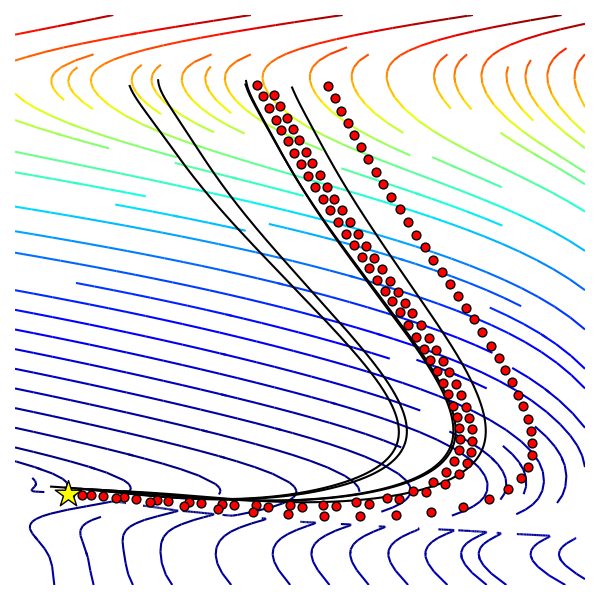

In [48]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

steps = 20
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="jet", linewidth=1.5, arrowstyle='-', arrowsize=1.5)
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=10)

for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=1.5)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="8%", pad=0.2)
# cax.yaxis.set_label_position("right")
# norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
# colors = plt.cm.jet(norm(potential))
# mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
# cbar = fig.colorbar(mappable, cax=cax)
# cbar.outline.set_visible(False)
# cbar.ax.tick_params(size=0)
# cbar.set_ticks([])
# cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=20)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_field_second.png', format='png', dpi=300, bbox_inches="tight")

### Streamlines

In [45]:
# x0 = TorchHelper.grid_uniform(center=train_x[0,:].detach(), length=0.01, samples=3).to(device).requires_grad_(True)
x0 = TorchHelper.grid_uniform(center=train_x[0,:].detach(), la=0.1, lb=0.01, samples=5).to(device).requires_grad_(True)
v0 = torch.zeros_like(x0).to(device).requires_grad_(True)
streamlines = Integrator.second_order(dynamics=model,x0=torch.cat((x0,v0),dim=1),T=6.5, dt=0.01).cpu().detach().numpy()

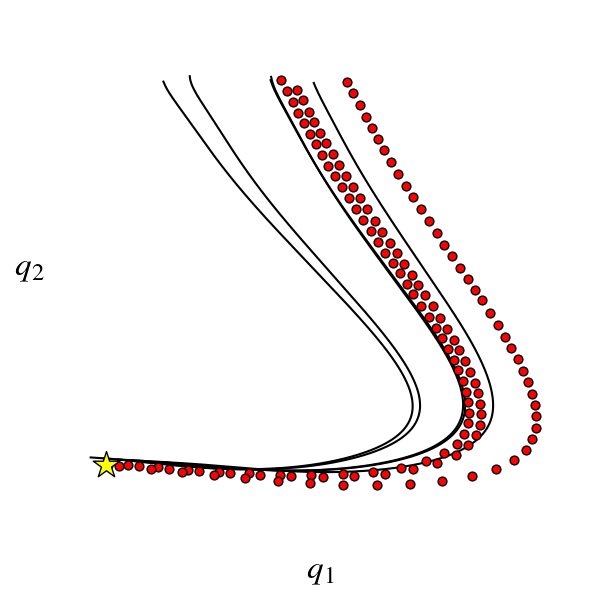

In [46]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

steps = 20
for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=1.5)

ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=10)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel(r'$q_1$', fontsize=24)
ax.set_ylabel(r'$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_streamlines_second.png', format='png', dpi=300, bbox_inches="tight")

### Embedding

In [14]:
grid_embedding = embedding(grid_x)
x_embedding = grid_embedding[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_embedding = grid_embedding[:, 1].reshape(resolution, -1).cpu().detach().numpy()
z_embedding = grid_embedding[:, 2].reshape(resolution, -1).cpu().detach().numpy()
train_embedding = embedding(train_x[:,:dim]).cpu().detach().numpy()

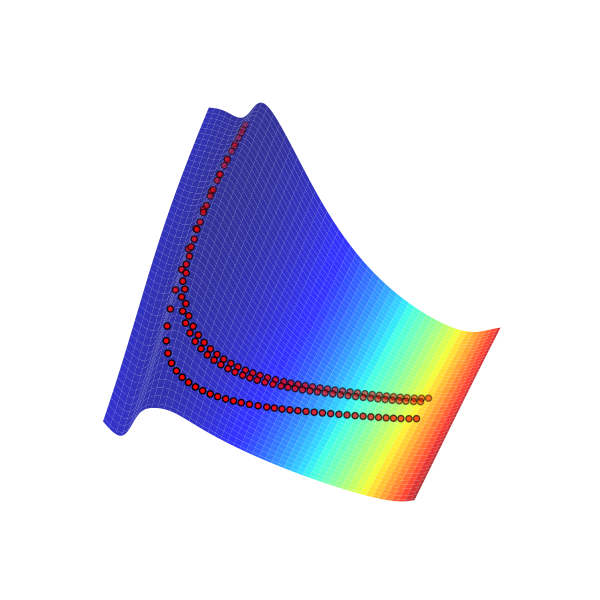

In [49]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d", computed_zorder=False)

steps = 20
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))

im = ax.plot_surface(x_embedding, y_embedding, z_embedding, cmap='jet', edgecolor='none', antialiased=True, alpha=0.8, facecolors=colors)
ax.scatter(train_embedding[::steps, 0], train_embedding[::steps, 1], train_embedding[::steps, 2], s=20, edgecolors='k', c='red', zorder=10)

ax.set_xlabel('$y^1$')
ax.set_ylabel('$y^2$')
ax.set_zlabel('$y^3$')

# Adjust plot limits, if necessary
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# ax.set_zlim(z_min, z_max)

ax.axis('off')

ax.view_init(elev=30, azim=18)  # Adjust the elevation (up/down) and azimuth (left/right) an

# # Add colorbar without ticks and labels
# mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
# cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
# cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=10)

# cbar.ax.set_yticklabels([])
# cbar.ax.tick_params(length=0)
# cbar.outline.set_visible(False)  # Remove colorbar frame

# # Shrink colorbar to dimensions of the plot
# cbar.ax.set_position([0.52, 0.1, 0.03, 0.8])  # Adjust colorbar position and width

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_embedding_second.png', format='png', dpi=300, bbox_inches="tight")

### Metric

In [62]:
metric = model.embedding.pullmetric(grid_embedding, model.embedding.jacobian(grid_x, grid_embedding))
det_metric = metric.det().reshape(resolution, -1).detach().cpu().numpy()

red_embedding = embedding(grid_xr)
metric_r = embedding.pullmetric(red_embedding, embedding.jacobian(grid_xr, red_embedding))
evals,evecs = torch.linalg.eigh(metric_r)
evals /= torch.tensor([100,10000]).to(device)

ellipses = torch.stack((evals[:, 0].unsqueeze(-1)*theta.cos(), evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
ellipses = torch.bmm(evecs, ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()
ellipses_x = x[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 0]
ellipses_y = y[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 1]

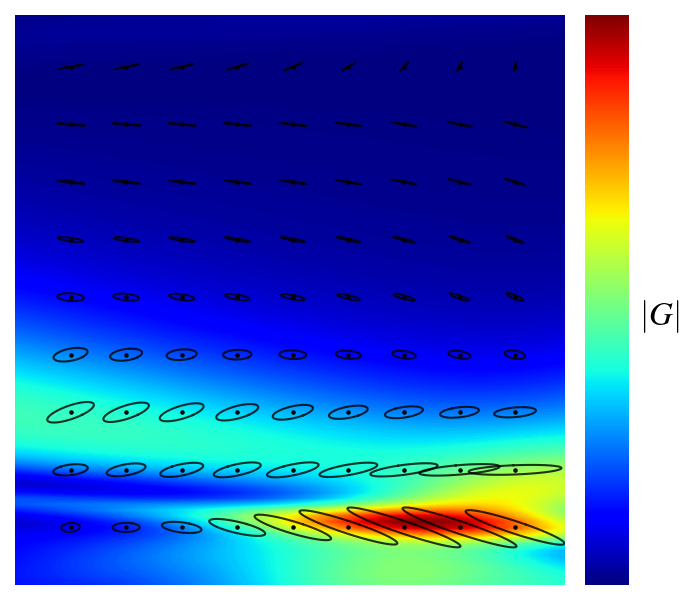

In [63]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Plot the filled contour
contour = ax.contourf(x, y, det_metric, 500, cmap="jet")

# Plot scattered points
ax.scatter(x[10::10, 10::10], y[10::10, 10::10], color="k", s=5)

# Plot ellipses
for i in range(ellipses.shape[0]):
    ax.plot(ellipses_x[i, :], ellipses_y[i, :], color="k", linewidth=1.5, alpha=0.8)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.2)
cax.yaxis.set_label_position("right")
norm = plt.Normalize(vmin=det_metric.min(), vmax=det_metric.max())
colors = plt.cm.jet(norm(det_metric))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label(r'$|G|$', fontsize=24, rotation=0, labelpad=25)

# Set labels and tick sizes
# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_detmetric_second.png', format='png', dpi=300, bbox_inches="tight")

### Inverse Metric Ellispses on Streamlines

In [18]:
eval_scale = 10
x_sampled = torch.from_numpy(streamlines[:, 0, :dim]).float().to(device).requires_grad_(True)
v_sampled = torch.from_numpy(streamlines[:, 0, dim:]).float().to(device).requires_grad_(True)
sampled_embedding = embedding(x_sampled)

metric_sampled = model.embedding.pullmetric(sampled_embedding, model.embedding.jacobian(x_sampled, sampled_embedding))
metric_evals,metric_evecs = torch.linalg.eigh(metric_sampled.inverse())
metric_evals/= torch.tensor([100,100]).to(device)

metric_ellipses = torch.stack((metric_evals[:, 0].unsqueeze(-1)*theta.cos(), metric_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
metric_ellipses = torch.bmm(metric_evecs, metric_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()

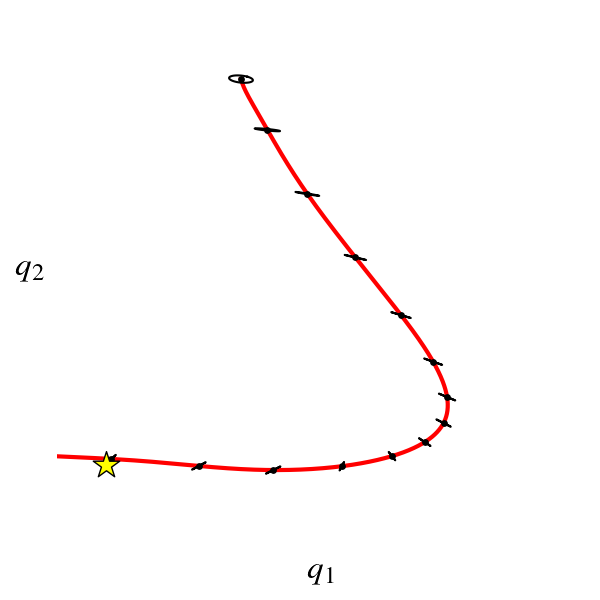

In [19]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

step = 50
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='r', linewidth='3')

ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=15, zorder=10)

for i in range(0, metric_ellipses.shape[0], step):
    ax.plot(x_sampled[i, 0].detach().cpu() + metric_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + metric_ellipses[i, :, 1], color="k", linewidth=1.5)
    
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

# Set labels and tick sizes
ax.set_xlabel('$q_1$', fontsize=24)
ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_metric_second.png', format='png', dpi=300, bbox_inches="tight")

### Christoffel Symbols Ellispses on Streamlines

In [20]:
christoffel_sampled = embedding.christoffel(x_sampled, metric_sampled)
christoffel_sampled = torch.einsum('bqij,bi->bqj', christoffel_sampled, v_sampled)
christoffel_evals,christoffel_evecs = torch.linalg.eig(christoffel_sampled)
christoffel_evals = torch.real(christoffel_evals)
christoffel_evecs = torch.real(christoffel_evecs)
christoffel_evals/= torch.tensor([20,0.000001]).to(device)

christoffel_ellipses = torch.stack((christoffel_evals[:, 0].unsqueeze(-1)*theta.cos(), christoffel_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
christoffel_ellipses = torch.bmm(christoffel_evecs, christoffel_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()

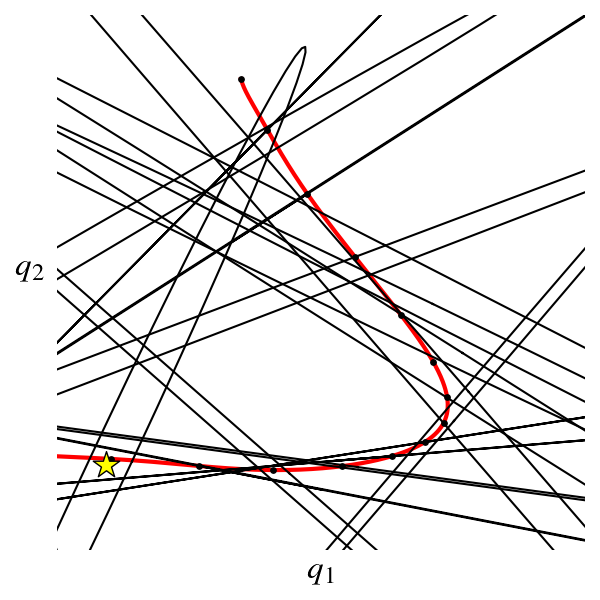

In [21]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

step = 50
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='r', linewidth='3')

ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=15, zorder=10)

for i in range(0,christoffel_ellipses.shape[0],step):
    ax.plot(x_sampled[i, 0].detach().cpu() + christoffel_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + christoffel_ellipses[i, :, 1], color="k", linewidth=1.5)
    
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

if hasattr(embedding, 'local_deformation'):
    for i in range(obstacle.shape[0]):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)
        
# Set labels and tick sizes
ax.set_xlabel('$q_1$', fontsize=24)
ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_christoffel_second.png', format='png', dpi=300, bbox_inches="tight")